# Physiology Lab - Fall 2019
# Oxygen Equilibrium of Hemocyanin Report

For this report, Dr. Beers only wants three graphs generated from the data obtained during lab. 

1. Plot % Oxygen Saturation (y-axis) as a funciton of oxygen partial pressure (x-axis). Determine the P<sub>50</sub> of the pigment under the experimental conditions.

In [1]:
hemodat = read.csv('OxygenEqHemo.csv')
hemodat$pH = as.factor(hemodat$pH)

In [2]:
hemodat$hill = log((hemodat$Percent.Oxy.Sat)*100/(100-(hemodat$Percent.Oxy.Sat*100)))
max(hemodat$PO2)

[1] 745.8839

In [3]:
(hemodat)

pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
7.3,0,0.007,764.2500,24.19500,610,0.000000,0.00000000,-Inf
7.3,5,0.017,764.2500,24.19500,610,6.066025,0.03717472,-3.2542430
7.3,15,0.027,764.2500,24.19500,610,18.198074,0.07434944,-2.5217206
7.3,35,0.070,764.2500,24.19500,610,42.462172,0.23420074,-1.1847414
7.3,55,0.153,764.2500,24.19500,610,66.726270,0.54275093,0.1714223
7.3,65,0.194,764.2500,24.19500,610,78.858320,0.69516729,0.8243894
7.3,70,0.201,764.2500,24.19500,610,84.924344,0.72118959,0.9503700
7.3,75,0.223,764.2500,24.19500,610,90.990369,0.80297398,1.4049865
7.3,NA,0.276,764.2500,24.19500,610,740.115910,1.00000000,Inf


In [4]:
hem_73 = hemodat[hemodat$pH == '7.3',]
hem_68 = hemodat[hemodat$pH == '6.8',]
hem_78 = hemodat[hemodat$pH == '7.8',]
hem_73
hem_68
a = rbind(hem_68, hem_73)

pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
7.3,0,0.007,764.25,24.195,610,0.000000,0.00000000,-Inf
7.3,5,0.017,764.25,24.195,610,6.066025,0.03717472,-3.2542430
7.3,15,0.027,764.25,24.195,610,18.198074,0.07434944,-2.5217206
7.3,35,0.070,764.25,24.195,610,42.462172,0.23420074,-1.1847414
7.3,55,0.153,764.25,24.195,610,66.726270,0.54275093,0.1714223
7.3,65,0.194,764.25,24.195,610,78.858320,0.69516729,0.8243894
7.3,70,0.201,764.25,24.195,610,84.924344,0.72118959,0.9503700
7.3,75,0.223,764.25,24.195,610,90.990369,0.80297398,1.4049865
7.3,NA,0.276,764.25,24.195,610,740.115910,1.00000000,Inf


,pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
10,6.8,0,0.049,768.8132,22.92939,635,0.00000,0.00000000,-Inf
11,6.8,10,0.056,768.8132,22.92939,635,11.74620,0.02017291,-3.8830355
12,6.8,20,0.077,768.8132,22.92939,635,23.49240,0.08069164,-2.4329866
13,6.8,40,0.103,768.8132,22.92939,635,46.98481,0.15561960,-1.6911886
14,6.8,60,0.141,768.8132,22.92939,635,70.47721,0.26512968,-1.0194750
15,6.8,80,0.179,768.8132,22.92939,635,93.96961,0.37463977,-0.5123629
16,6.8,100,0.195,768.8132,22.92939,635,117.46202,0.42074928,-0.3196983
17,6.8,NA,0.396,768.8132,22.92939,635,745.88390,1.00000000,Inf


In [5]:
require(nlme)
require(ggplot2)
require(ggpubr)

Loading required package: nlme

Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: magrittr



In [6]:
fit_68 = nls(Percent.Oxy.Sat~SSlogis(PO2, Asym, xmid, scal), data=hem_68)
summary(fit_68)


Formula: Percent.Oxy.Sat ~ SSlogis(PO2, Asym, xmid, scal)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
Asym   0.99616    0.04585  21.726 3.83e-06 ***
xmid 122.67788    7.96433  15.403 2.09e-05 ***
scal  42.23482    6.57186   6.427  0.00135 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.04589 on 5 degrees of freedom

Number of iterations to convergence: 0 
Achieved convergence tolerance: 8.352e-06


In [7]:
hem_68

,pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
10,6.8,0,0.049,768.8132,22.92939,635,0.00000,0.00000000,-Inf
11,6.8,10,0.056,768.8132,22.92939,635,11.74620,0.02017291,-3.8830355
12,6.8,20,0.077,768.8132,22.92939,635,23.49240,0.08069164,-2.4329866
13,6.8,40,0.103,768.8132,22.92939,635,46.98481,0.15561960,-1.6911886
14,6.8,60,0.141,768.8132,22.92939,635,70.47721,0.26512968,-1.0194750
15,6.8,80,0.179,768.8132,22.92939,635,93.96961,0.37463977,-0.5123629
16,6.8,100,0.195,768.8132,22.92939,635,117.46202,0.42074928,-0.3196983
17,6.8,NA,0.396,768.8132,22.92939,635,745.88390,1.00000000,Inf


In [8]:
fit_73 = nls(Percent.Oxy.Sat~SSlogis(PO2,Asym,xmid,scal), data=hem_73)
summary(fit_73)
#plot(Percent.Oxy.Sat~PO2,data=hem_73,type="p")
nd = seq(from = 0, to = max(hem_73$PO2), 0.1)
#points(predict(fit73, newdata=nd)~PO2, data=hem_73, type="l")


Formula: Percent.Oxy.Sat ~ SSlogis(PO2, Asym, xmid, scal)

Parameters:
     Estimate Std. Error t value Pr(>|t|)    
Asym  0.99365    0.01769   56.18 2.14e-09 ***
xmid 64.32310    1.14968   55.95 2.19e-09 ***
scal 18.46605    0.83129   22.21 5.44e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01831 on 6 degrees of freedom

Number of iterations to convergence: 0 
Achieved convergence tolerance: 3.583e-06


In [9]:
# This ultimately refused to fit because we had less than 5 data points
fit_78 = nls(Percent.Oxy.Sat~SSlogis(PO2, Asym, xmid, scal), data = hem_78)
summary(fit_78)


Formula: Percent.Oxy.Sat ~ SSlogis(PO2, Asym, xmid, scal)

Parameters:
     Estimate Std. Error t value Pr(>|t|)    
Asym  0.97793    0.02209  44.263 0.000510 ***
xmid 25.95895    0.63302  41.008 0.000594 ***
scal  3.30560    0.63057   5.242 0.034516 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02705 on 2 degrees of freedom

Number of iterations to convergence: 2 
Achieved convergence tolerance: 6.58e-06


[1] 0.05172435 0.06719061 0.08685618 0.14225577 0.22427564 0.33503116 0.46736483
[8] 0.99616259

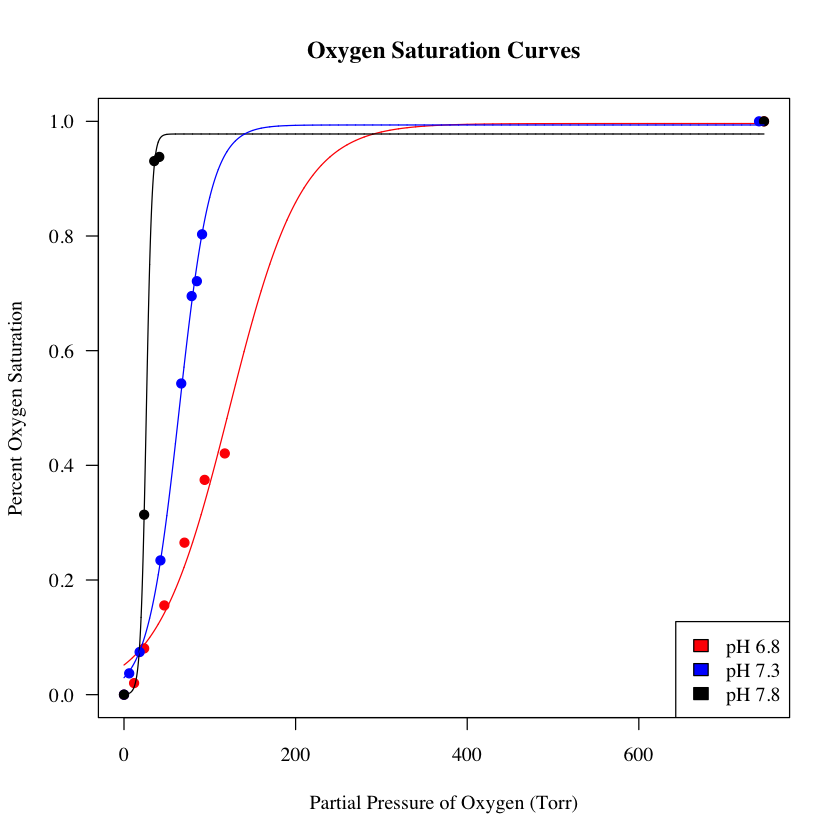

In [10]:
predict(fit_68)
opar = par(las = 1)
#pdf(file="OxygenSatCurves.pdf")
par(family = "serif")
plot(Percent.Oxy.Sat ~ PO2, data = hem_68, ylim=c(0,1), main = "Oxygen Saturation Curves",
    ylab="Percent Oxygen Saturation",
    xlab="Partial Pressure of Oxygen (Torr)",
    col="red", pch = 19)
legend("bottomright", 
        c("pH 6.8", "pH 7.3", "pH 7.8"),
        fill=c("red","blue", "black"))
tt = seq(0, max(hem_78$PO2), 0.1)
lines(tt, predict(fit_68, list(PO2 = tt)), col="red")
points(x = hem_73$PO2, y = hem_73$Percent.Oxy.Sat, pch = 19, col = "blue")
points(x = hem_78$PO2, y = hem_78$Percent.Oxy.Sat, pch = 19)
lines(tt, predict(fit_78, list(PO2 = tt), col = "black"))
lines(tt, predict(fit_73, list(PO2 = tt)), col = "blue")
#dev.off()
par(opar)

2. Estimate the cooperativity of the hemocyanin (i.e. Create a Hill Plot). An estimate of cooperativity between hemocyanin subunits can be obtained by plotting the log of percent saturation ove rpercent unsaturation as a function of the log of Po<sub>2</sub> and measuring the slope of the line around P<sub>50</sub> (n or sometimes n<sub>50</sub>). This number is an indec of cooperativity. The higher the number, the grater the cooperativity.

In [11]:
hem_731 = hem_73[hem_73$PO2 != 0,]
hem_732 = hem_731[hem_731$Percent.Oxy.Sat != 1,]
hem_781 = hem_78[hem_78$PO2 != 0,]
hem_782 = hem_781[hem_781$Percent.Oxy.Sat != 1,]
hem_681 = hem_68[hem_68$PO2 != 0,]
hem_682 = hem_681[hem_681$Percent.Oxy.Sat != 1,]
hem_682

,pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
11,6.8,10,0.056,768.8132,22.92939,635,11.74620,0.02017291,-3.8830355
12,6.8,20,0.077,768.8132,22.92939,635,23.49240,0.08069164,-2.4329866
13,6.8,40,0.103,768.8132,22.92939,635,46.98481,0.15561960,-1.6911886
14,6.8,60,0.141,768.8132,22.92939,635,70.47721,0.26512968,-1.0194750
15,6.8,80,0.179,768.8132,22.92939,635,93.96961,0.37463977,-0.5123629
16,6.8,100,0.195,768.8132,22.92939,635,117.46202,0.42074928,-0.3196983



Call:
lm(formula = hill ~ log(PO2), data = hem_732)

Residuals:
      2       3       4       5       6       7       8 
 0.5685 -0.6034 -0.7352 -0.1625  0.2009  0.1984  0.5334 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.9476     0.8784  -7.909 0.000520 ***
log(PO2)      1.7335     0.2295   7.552 0.000645 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5689 on 5 degrees of freedom
Multiple R-squared:  0.9194,	Adjusted R-squared:  0.9033 
F-statistic: 57.03 on 1 and 5 DF,  p-value: 0.0006453


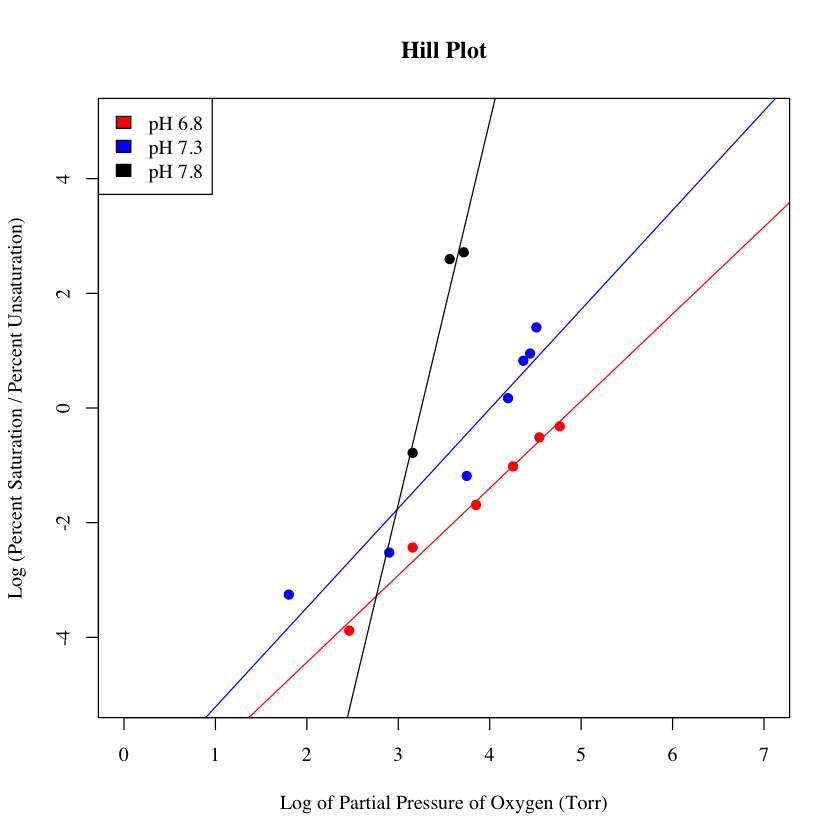

In [12]:
summary(lm(hill~log(PO2), data=hem_732))
#pdf(file="HillPlot.pdf")
par(family = 'serif')
plot(hill~log(PO2), data=hem_732, xlim = c(0, 7), ylim=c(-5,5), col="blue",
    xlab="Log of Partial Pressure of Oxygen (Torr)",
    ylab="Log (Percent Saturation / Percent Unsaturation)",
    main="Hill Plot",
    pch = 19)
legend("topleft",
      c("pH 6.8", "pH 7.3", "pH 7.8"),
        fill=c("red","blue", "black"))
abline(a = -6.948, b = 1.733, col="blue")
# Adding pH 6.8 to the graph
points(x=log(hem_682$PO2), y=hem_682$hill, col="red", pch = 19)
abline(a = -7.47379, b = 1.51877, col="red")
# Adding pH 7.8 to the graph
points(x=log(hem_782$PO2), y=hem_782$hill, col="black", pch = 19)
abline(a=-21.704, b=6.674, col="black")
#dev.off()

In [13]:
b = rbind(hem_732, hem_682, hem_782)
anc = lm(hill ~ log(PO2)*pH, data=b)
summary(anc)


Call:
lm(formula = hill ~ log(PO2) * pH, data = b)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.73519 -0.15372 -0.03645  0.21228  0.56847 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -7.4738     0.9253  -8.077 1.08e-05 ***
log(PO2)         1.5188     0.2359   6.438 7.46e-05 ***
pH7.3            0.5262     1.1712   0.449  0.66284    
pH7.8          -14.2306     4.0726  -3.494  0.00578 ** 
log(PO2):pH7.3   0.2147     0.3014   0.712  0.49259    
log(PO2):pH7.8   5.1552     1.1618   4.437  0.00126 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.465 on 10 degrees of freedom
Multiple R-squared:  0.962,	Adjusted R-squared:  0.943 
F-statistic: 50.66 on 5 and 10 DF,  p-value: 8.835e-07


In [15]:
summary(lm(hill~log(PO2), data=hem_68[hem_68$PO2 != 0,]))
plot(hill~log(PO2), data=hem_68[hem_68$PO2 != 0,])
abline(a = -7.47379, b = 1.51877)

ERROR: Error in lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...): NA/NaN/Inf in 'y'


In [16]:
# This one is terrible
#summary(lm(hill~log(PO2), data=hem_78))
#plot(hill~log(PO2), data=hem_78)
#abline(a = -21.704, b = 6.674)

3. Create a magnitude of Bohr Shift graph.


Call:
lm(formula = log(p501) ~ pH1)

Residuals:
       1        2        3 
-0.04363  0.08725 -0.04363 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  15.4139     1.1050   13.95   0.0456 *
pH1          -1.5530     0.1511  -10.28   0.0618 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1069 on 1 degrees of freedom
Multiple R-squared:  0.9906,	Adjusted R-squared:  0.9812 
F-statistic: 105.6 on 1 and 1 DF,  p-value: 0.06176


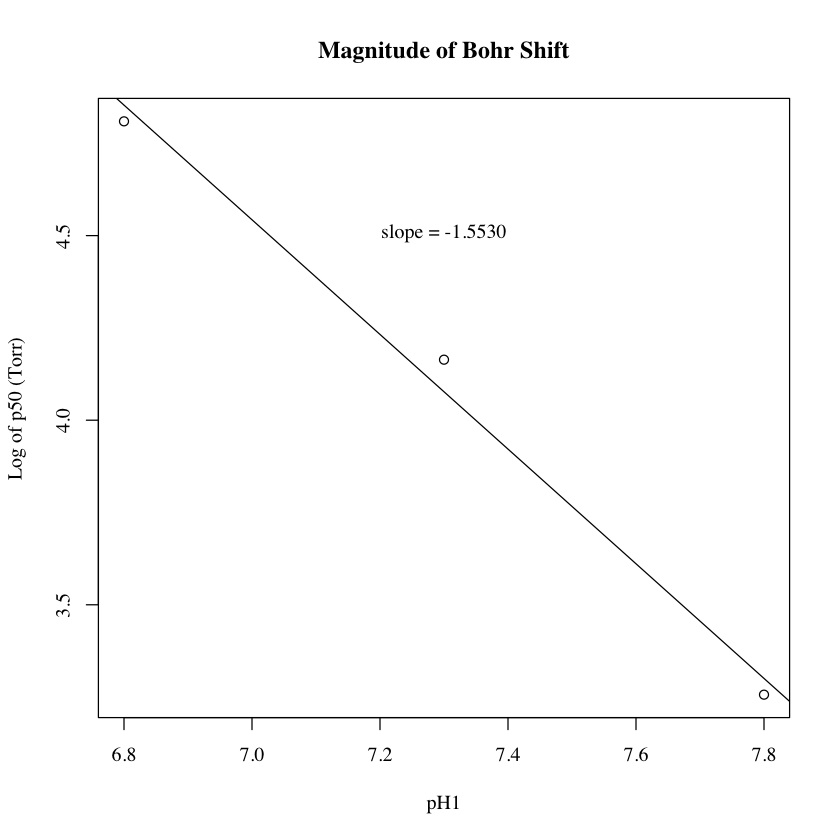

In [21]:
p501 = c(122.67788, 64.32310, 25.9589)
pH1 = c(6.8, 7.3, 7.8)
summary(lm(log(p501)~pH1))
#pdf(file="MagnitudeBohrShift2.pdf")
par(family = 'serif')
plot(log(p501)~pH1, main="Magnitude of Bohr Shift",
    ylab="Log of p50 (Torr)")
abline(a = 15.4139, b=-1.5530)
mtext("slope = -1.5530", 3, line = -6, col = "black")
#dev.off()

In [18]:
# Now to do it with everyone's data
mag = read.csv('magborshift.csv')
head(mag)

pH,p50,Hill.Coeff
<dbl>,<dbl>,<dbl>
6.8,122.6779,1.51877
6.8,84.1170,0.85171
6.8,95.6000,0.55510
6.8,83.5000,1.52510
6.8,80.0000,2.09650
6.8,185.0000,0.68960



Call:
lm(formula = log(p50) ~ pH, data = mag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.93969 -0.30994 -0.07514  0.26986  1.30873 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  10.9477     2.5398    4.31 0.000421 ***
pH           -0.9273     0.3486   -2.66 0.015946 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6272 on 18 degrees of freedom
  (2 observations deleted due to missingness)
Multiple R-squared:  0.2822,	Adjusted R-squared:  0.2423 
F-statistic: 7.076 on 1 and 18 DF,  p-value: 0.01595


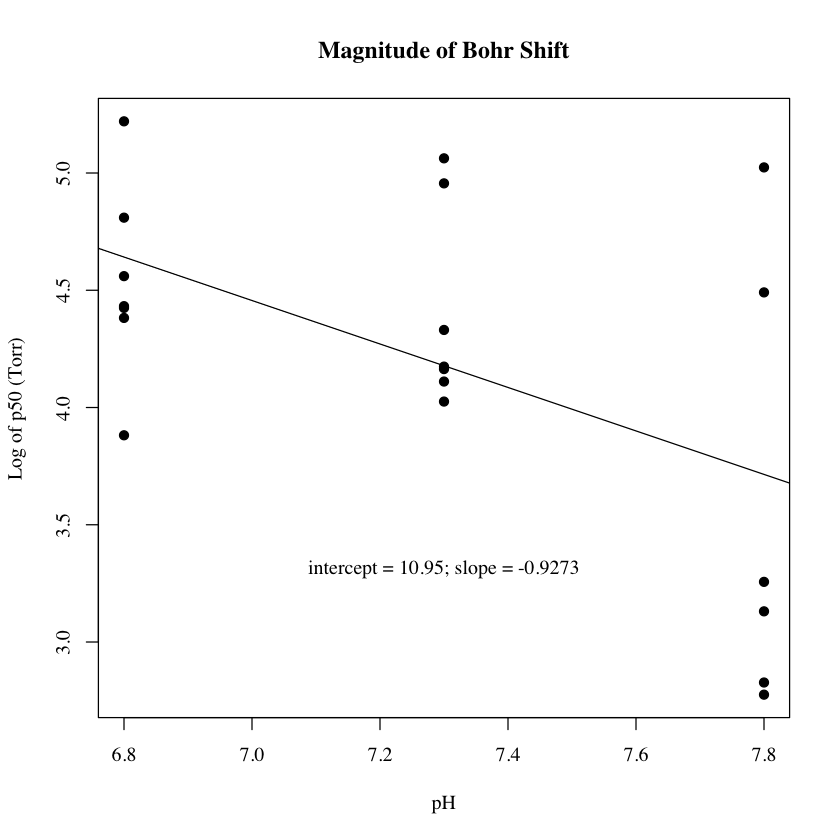

In [19]:
summary(lm(log(p50)~pH, data = mag))
#pdf(file="magbohrshift.pdf")
par(family = "serif")
plot(log(p50) ~ pH, data = mag, main="Magnitude of Bohr Shift",
    ylab="Log of p50 (Torr)", pch = 19)
mtext("intercept = 10.95; slope = -0.9273", 3, line = -20, col = "black")
abline(a = 10.9477, b = -0.9273)
#dev.off()